First part of code to import necessary data, initialize model and train it

shape of x_train: (5421, 28, 28), y_train: (5421,)


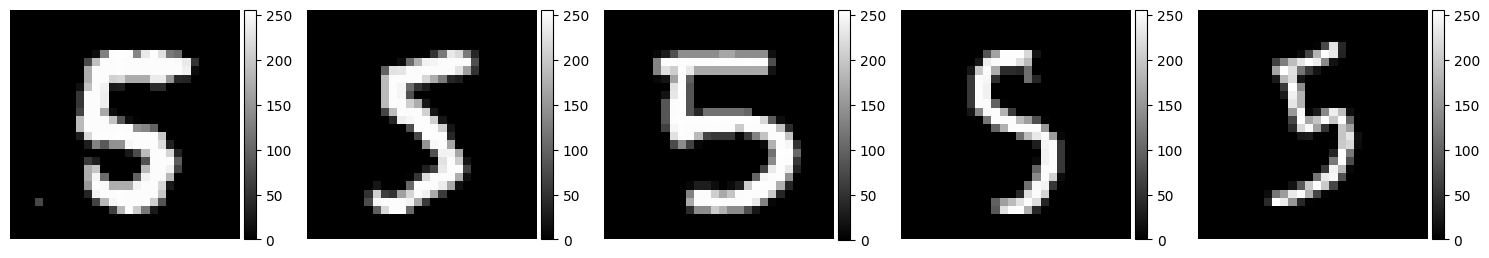

training maximum value 1.0


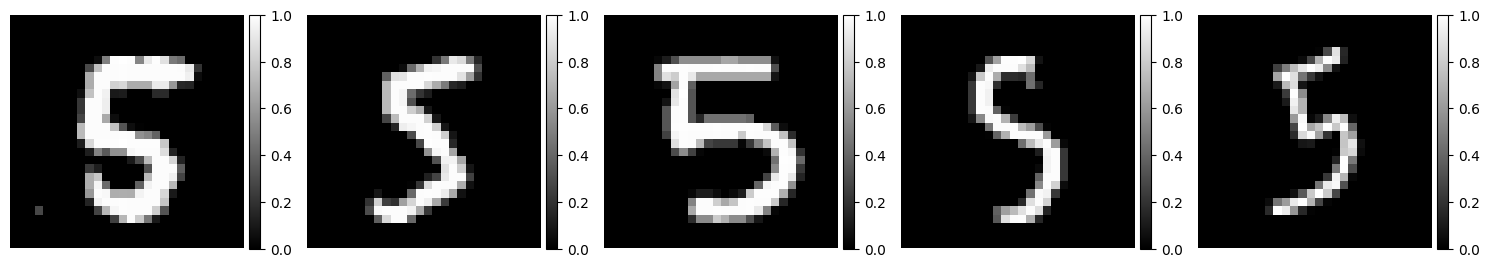

shape of training data (4421, 32, 32)
input shape:  (None, 32, 32, 2)
output shape: (None, 32, 32, 16)
displacement tensor: (None, 32, 32, 2)
input shape:  (None, 32, 32, 1), (None, 32, 32, 1)
output shape: (None, 32, 32, 1), (None, 32, 32, 2)


In [38]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
#assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
#print(tf.__version__)

# local imports
import voxelmorph as vxm
import neurite as ne

# You should most often have this import together with all other imports at the top, 
# but we include here here explicitly to show where data comes from
from tensorflow.keras.datasets import mnist

# load MNIST data. 
# `mnist.load_data()` already splits our data into train and test.  
(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()

digit_sel = 5

# extract only instances of the digit 5
x_train = x_train_load[y_train_load==digit_sel, ...]
y_train = y_train_load[y_train_load==digit_sel]
x_test = x_test_load[y_test_load==digit_sel, ...]
y_test = y_test_load[y_test_load==digit_sel]

# let's get some shapes to understand what we loaded.
print('shape of x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

nb_val = 1000  # keep 1,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]

nb_vis = 5

# choose nb_vis sample indexes
idx = np.random.choice(x_train.shape[0], nb_vis, replace=False)
example_digits = [f for f in x_train[idx, ...]]

# plot
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

# fix data
x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
x_test = x_test.astype('float')/255

# verify
print('training maximum value', x_train.max())

# re-visualize
example_digits = [f for f in x_train[idx, ...]]
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')

# verify
print('shape of training data', x_train.shape)

# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*x_train.shape[1:], unet_input_features)

# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)

print('input shape: ', unet.input.shape)
print('output shape:', unet.output.shape)

# transform the results into a flow field.
disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

# check tensor shape
print('displacement tensor:', disp_tensor.shape)

# using keras, we can easily form new models via tensor pointers
def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

# build transformer layer
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')

# extract the first frame (i.e. the "moving" image) from unet input tensor
moving_image = tf.expand_dims(unet.input[..., 0], axis=-1)

# warp the moving image with the transformer
moved_image_tensor = spatial_transformer([moving_image, disp_tensor])

outputs = [moved_image_tensor, disp_tensor]
vxm_model = tf.keras.models.Model(inputs=unet.inputs, outputs=outputs)

# build model using VxmDense
inshape = x_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)


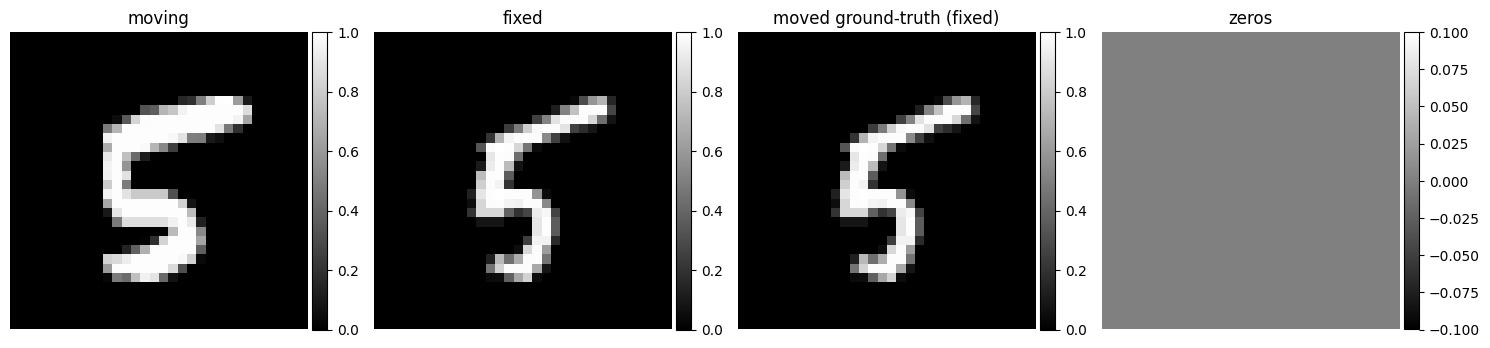

Epoch 1/10
100/100 - 7s - loss: 0.0500 - vxm_dense_transformer_loss: 0.0469 - vxm_dense_flow_loss: 0.0632 - 7s/epoch - 70ms/step
Epoch 2/10
100/100 - 4s - loss: 0.0237 - vxm_dense_transformer_loss: 0.0180 - vxm_dense_flow_loss: 0.1128 - 4s/epoch - 40ms/step
Epoch 3/10
100/100 - 4s - loss: 0.0190 - vxm_dense_transformer_loss: 0.0137 - vxm_dense_flow_loss: 0.1057 - 4s/epoch - 40ms/step
Epoch 4/10
100/100 - 4s - loss: 0.0169 - vxm_dense_transformer_loss: 0.0119 - vxm_dense_flow_loss: 0.1007 - 4s/epoch - 41ms/step
Epoch 5/10
100/100 - 4s - loss: 0.0155 - vxm_dense_transformer_loss: 0.0106 - vxm_dense_flow_loss: 0.0983 - 4s/epoch - 40ms/step
Epoch 6/10
100/100 - 4s - loss: 0.0145 - vxm_dense_transformer_loss: 0.0097 - vxm_dense_flow_loss: 0.0956 - 4s/epoch - 38ms/step
Epoch 7/10
100/100 - 4s - loss: 0.0133 - vxm_dense_transformer_loss: 0.0087 - vxm_dense_flow_loss: 0.0921 - 4s/epoch - 40ms/step
Epoch 8/10
100/100 - 4s - loss: 0.0127 - vxm_dense_transformer_loss: 0.0082 - vxm_dense_flow_loss

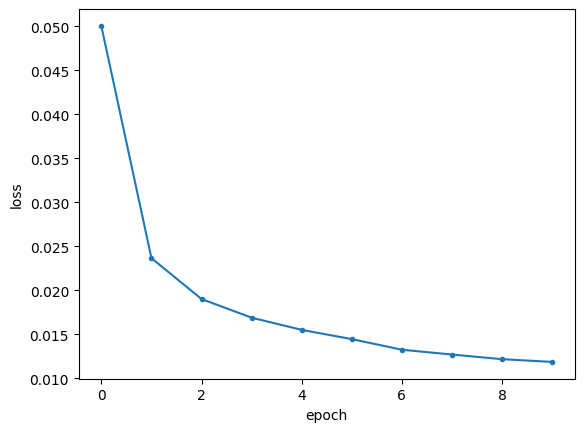

In [39]:
# let's test it
train_generator = vxm_data_generator(x_train)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

nb_epochs = 10
steps_per_epoch = 100
hist = vxm_model.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

Second part of code, to register data

1/1 [==============================] - 0s 20ms/step
57 ms ± 2.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


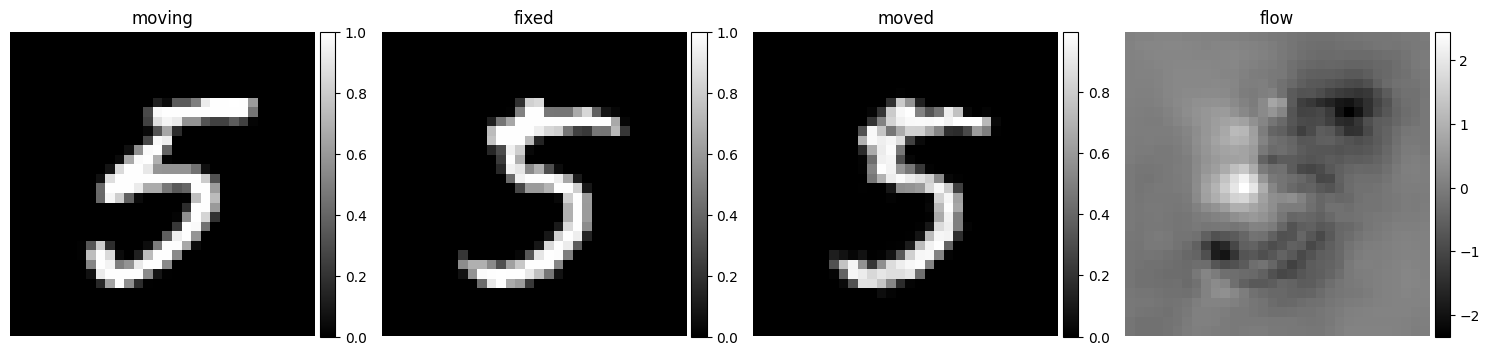

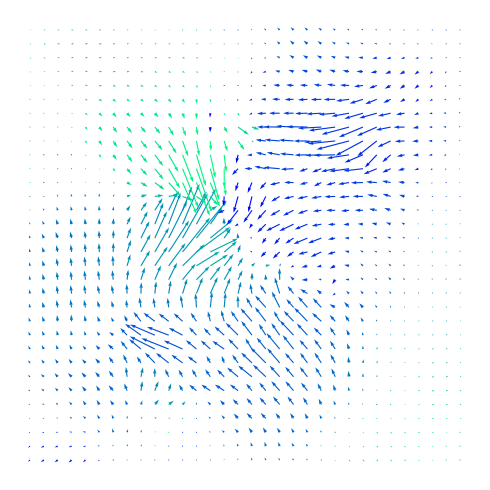

In [40]:
# let's get some data
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

val_pred = vxm_model.predict(val_input)

# %timeit is a 'jupyter magic' that times the given line over several runs
%timeit vxm_model.predict(val_input)

# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

ne.plot.flow([val_pred[1].squeeze()], width=5);

1/1 [==============================] - 0s 19ms/step


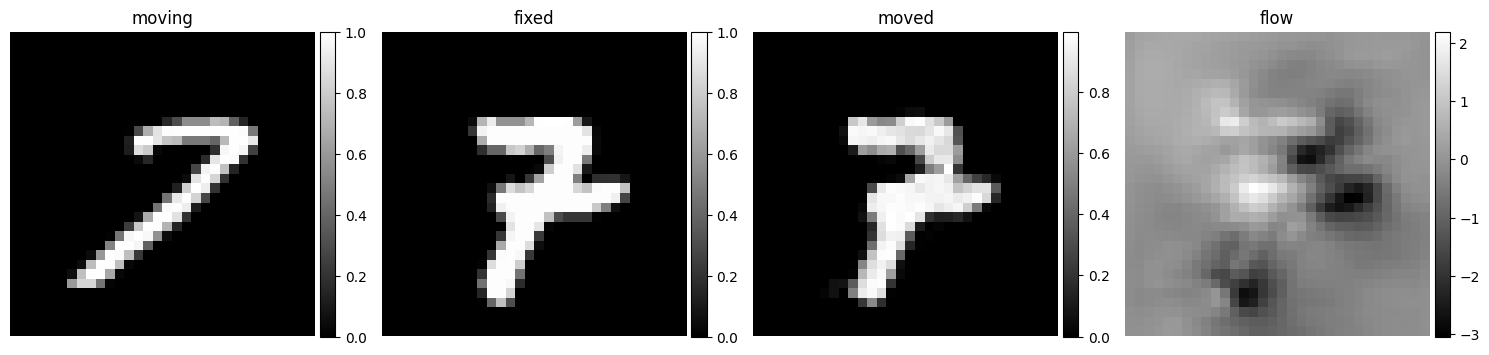

In [41]:
# extract only instances of the digit 7
x_sevens = x_train_load[y_train_load==7, ...].astype('float') / 255
x_sevens = np.pad(x_sevens, pad_amount, 'constant')

# predict
seven_generator = vxm_data_generator(x_sevens, batch_size=1)
seven_sample, _ = next(seven_generator)
seven_pred = vxm_model.predict(seven_sample)

# visualize
images = [img[0, :, :, 0] for img in seven_sample + seven_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

1/1 [==============================] - 0s 20ms/step


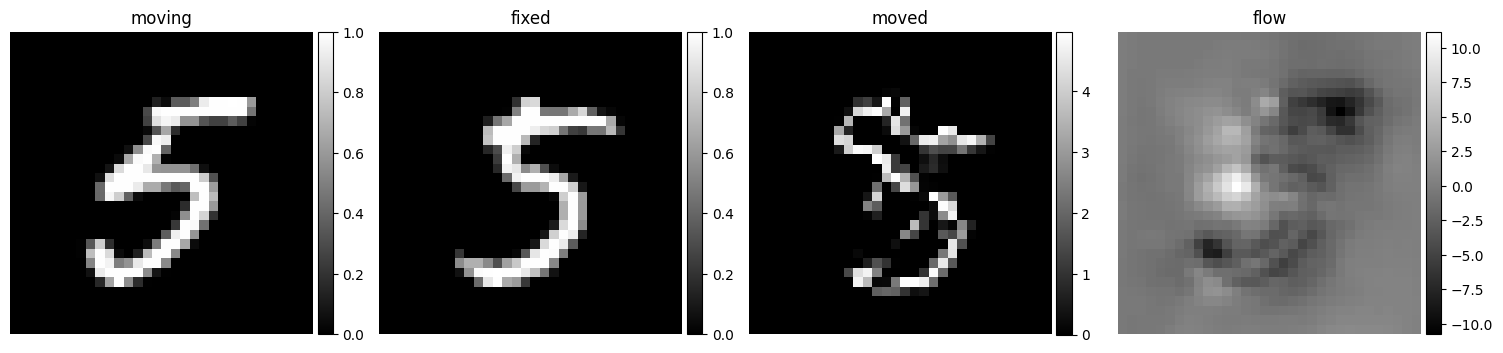

In [42]:
factor = 5
val_pred = vxm_model.predict([f * factor for f in val_input])

# visualizeb
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [43]:
# download MRI tutorial data
!python -m wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -o data.tar.gz
!tar -xzvf data.tar.gz


Saved under data.tar (1).gz


x brain_2d_no_smooth.h5
x brain_2d_smooth.h5
x brain_3d.h5
x fs_rgb.npy
x subj1.npz
x subj2.npz
x tutorial_data.npz: Can't unlink already-existing object: Permission denied
tar: Error exit delayed from previous errors.


train shape: (208, 192, 160)


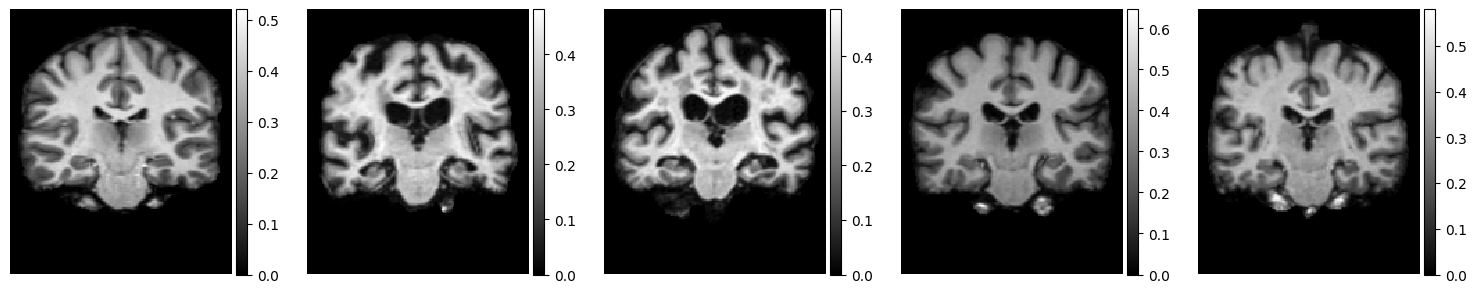

In [44]:
npz = np.load('tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

# the 208 volumes are of size 160x192
vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

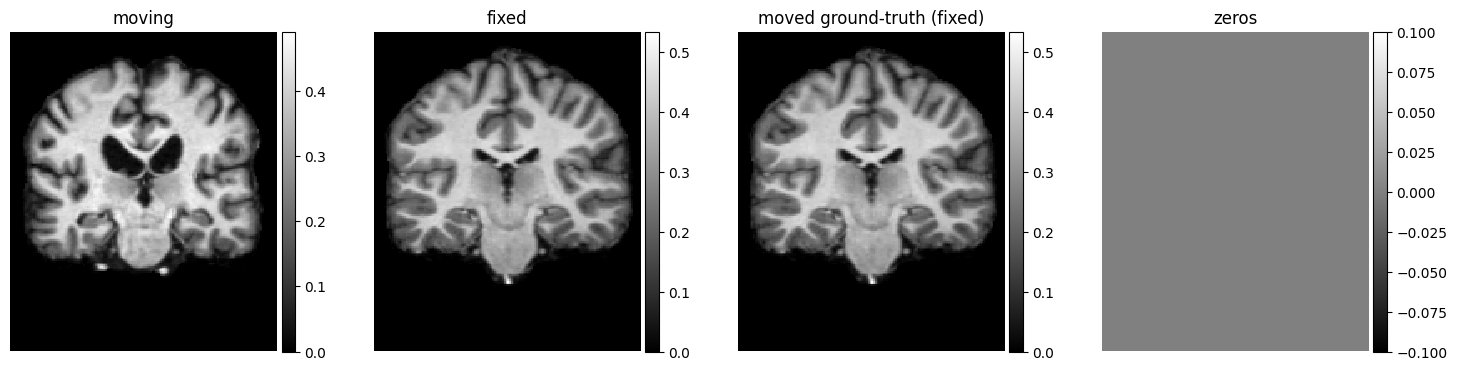

In [45]:
# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]

vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)

# let's test it
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Epoch 1/10
20/20 - 12s - loss: 0.0072 - vxm_dense_transformer_loss: 0.0072 - vxm_dense_flow_loss: 1.0373e-06 - 12s/epoch - 580ms/step
Epoch 2/10
20/20 - 7s - loss: 0.0070 - vxm_dense_transformer_loss: 0.0070 - vxm_dense_flow_loss: 4.5872e-05 - 7s/epoch - 364ms/step
Epoch 3/10
20/20 - 9s - loss: 0.0069 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 9.0800e-05 - 9s/epoch - 434ms/step
Epoch 4/10
20/20 - 8s - loss: 0.0066 - vxm_dense_transformer_loss: 0.0066 - vxm_dense_flow_loss: 7.2056e-05 - 8s/epoch - 400ms/step
Epoch 5/10
20/20 - 7s - loss: 0.0069 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 7.1319e-05 - 7s/epoch - 370ms/step
Epoch 6/10
20/20 - 7s - loss: 0.0069 - vxm_dense_transformer_loss: 0.0069 - vxm_dense_flow_loss: 1.0903e-04 - 7s/epoch - 361ms/step
Epoch 7/10
20/20 - 7s - loss: 0.0068 - vxm_dense_transformer_loss: 0.0068 - vxm_dense_flow_loss: 5.2824e-04 - 7s/epoch - 341ms/step
Epoch 8/10
20/20 - 7s - loss: 0.0060 - vxm_dense_transformer_loss: 0.0059 

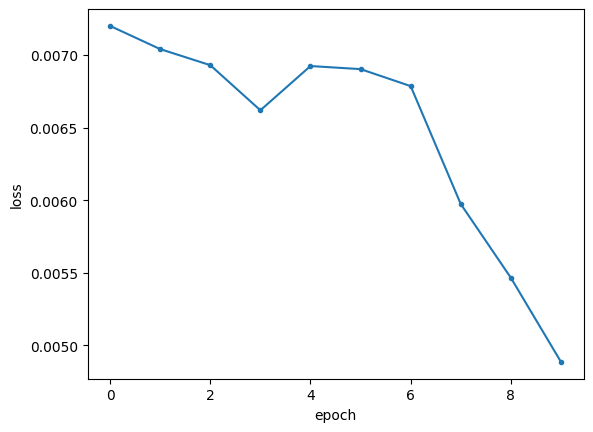

In [46]:
hist = vxm_model.fit(train_generator, epochs=10, steps_per_epoch=20, verbose=2);

# as before, let's visualize what happened
plot_history(hist)

1/1 [==============================] - 0s 382ms/step


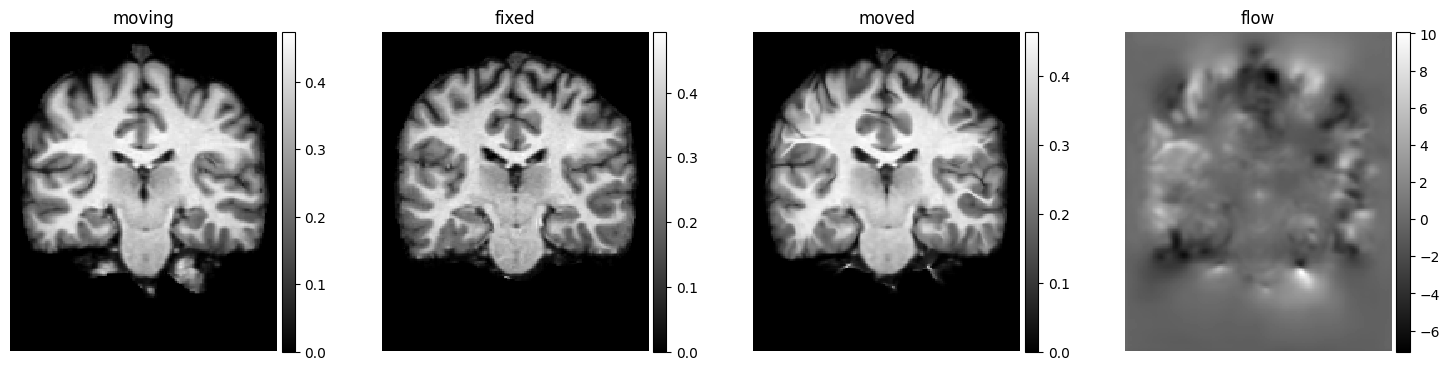

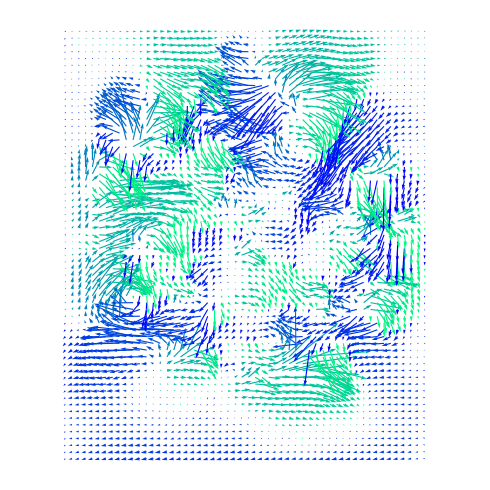

In [47]:
# load pretrained model weights
vxm_model.load_weights('brain_2d_smooth.h5')

# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

# prediction
val_pred = vxm_model.predict(val_input)

# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# visualize flow
flow = val_pred[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

# Evaluation

1/1 [==============================] - 0s 39ms/step


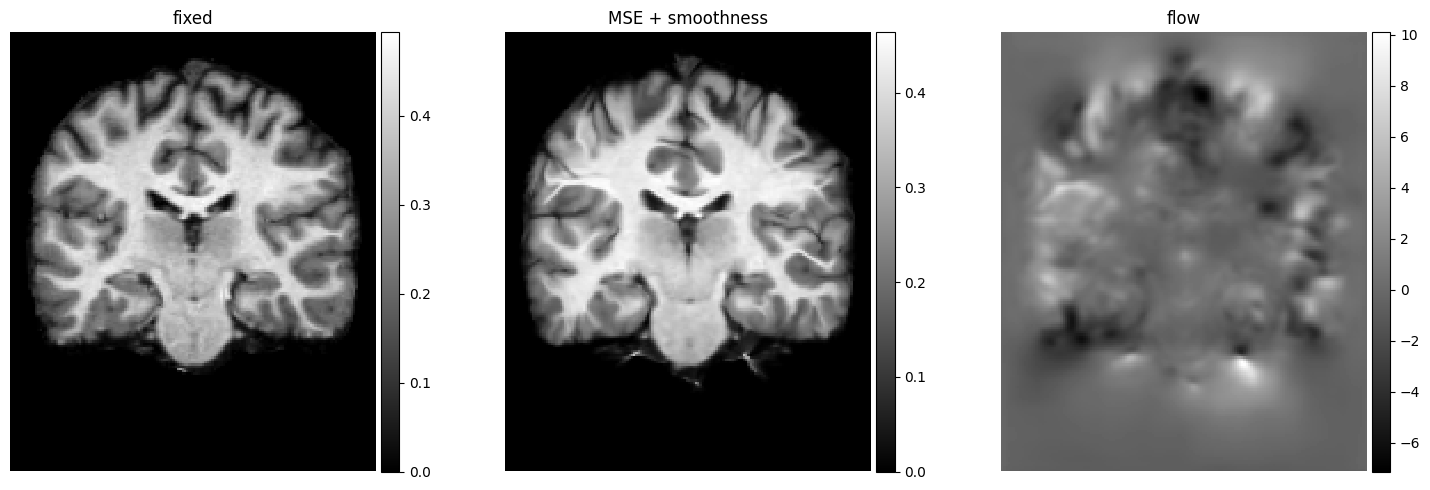

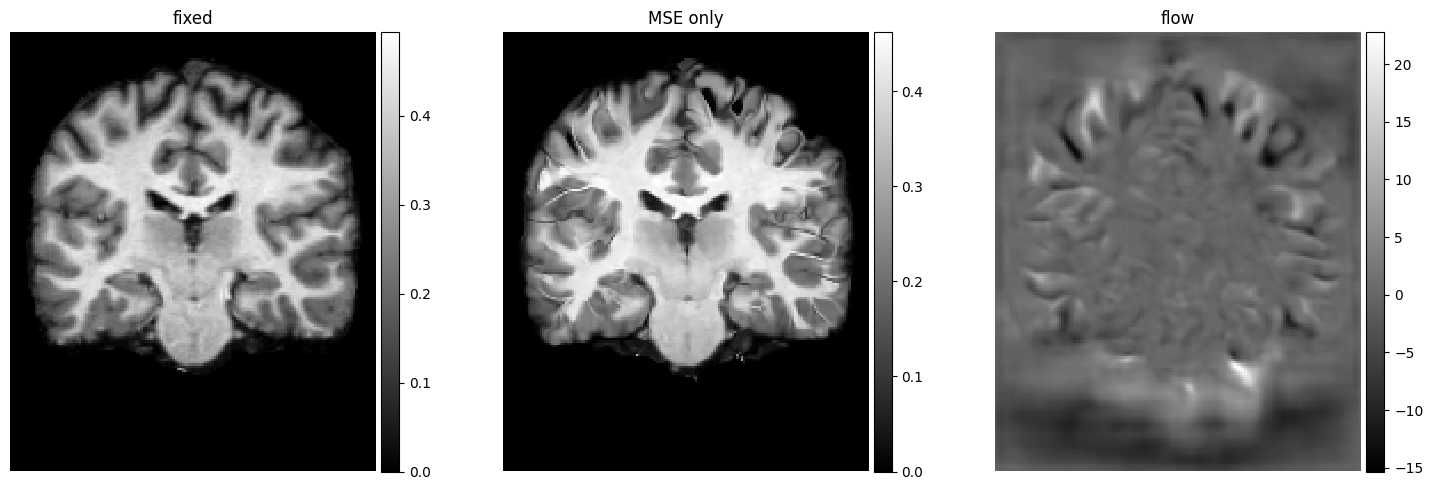

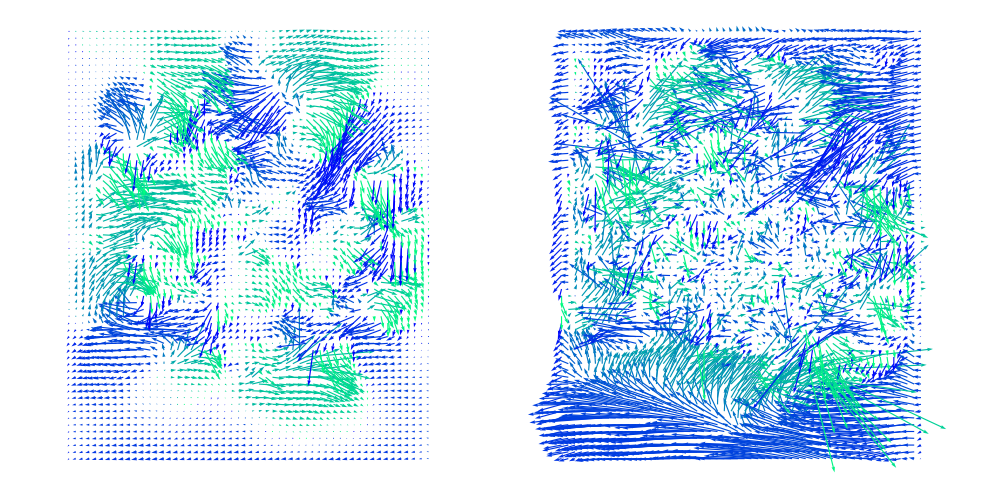

In [48]:
# prediction from model with MSE + smoothness loss
vxm_model.load_weights('brain_2d_smooth.h5')
our_val_pred = vxm_model.predict(val_input)

# prediction from model with just MSE loss
vxm_model.load_weights('brain_2d_no_smooth.h5')
mse_val_pred = vxm_model.predict(val_input)

# visualize MSE + smoothness model output
images = [img[0, ..., 0] for img in [val_input[1], *our_val_pred]]
titles = ['fixed', 'MSE + smoothness', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# visualize MSE model output
images = [img[0, ..., 0] for img in [val_input[1], *mse_val_pred]]
titles = ['fixed', 'MSE only', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

ne.plot.flow([img[1].squeeze()[::3, ::3] for img in [our_val_pred, mse_val_pred]], width=10);

1/1 [==============================] - 7s 7s/step


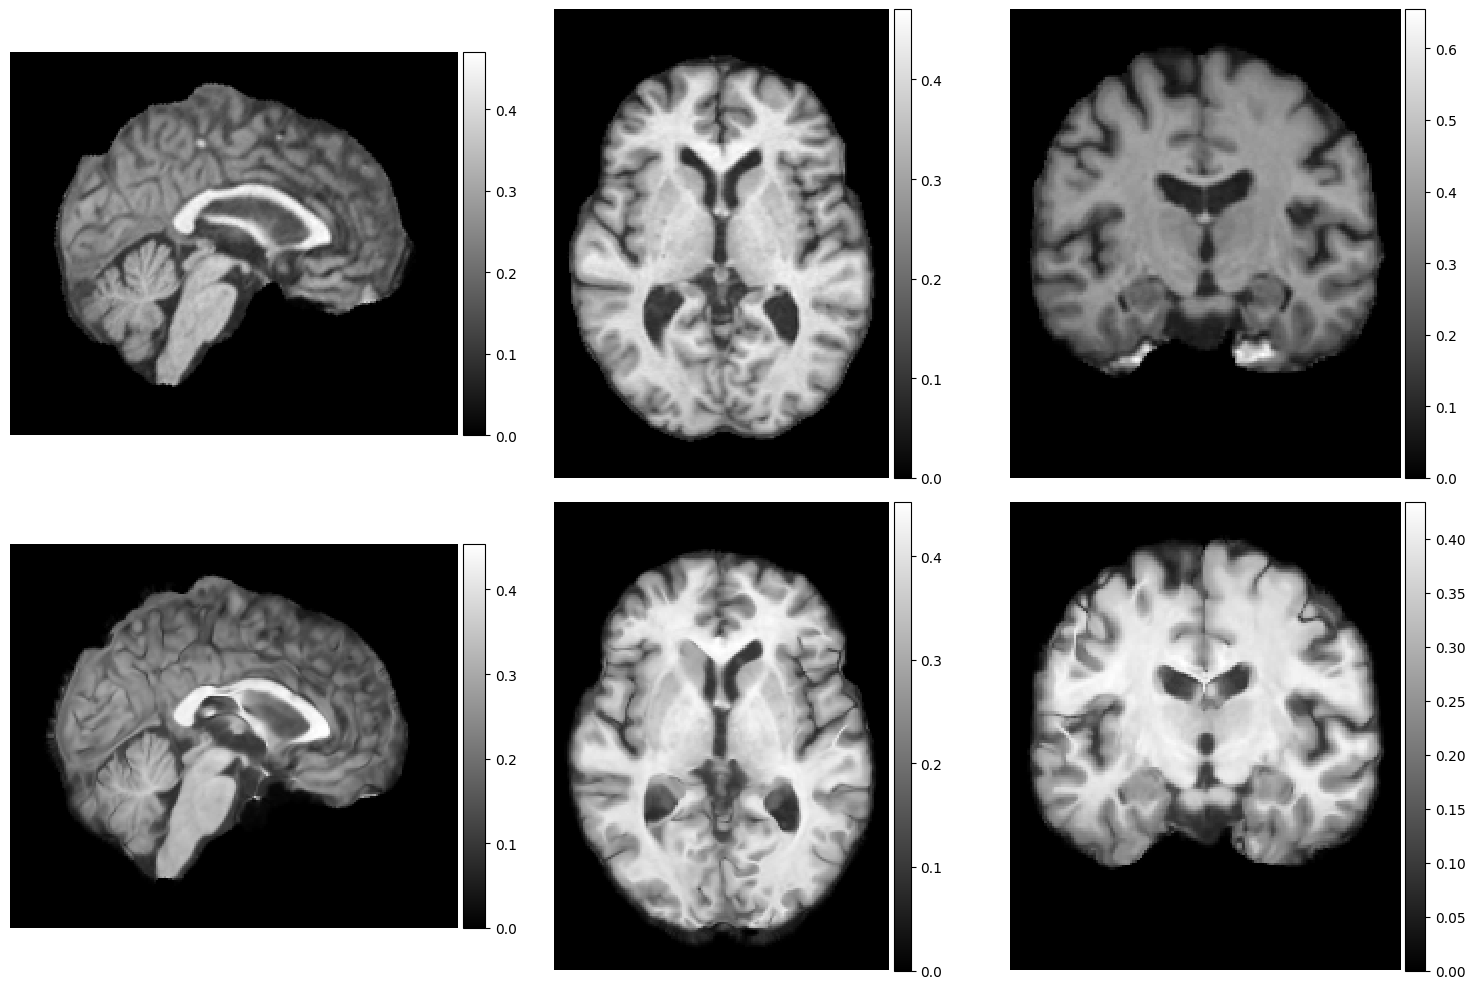

In [49]:
# our data will be of shape 160 x 192 x 224
vol_shape = (160, 192, 224)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

# build vxm network
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

# Prepairing validation data
val_volume_1 = np.load('subj1.npz')['vol']
seg_volume_1 = np.load('subj1.npz')['seg']
val_volume_2 = np.load('subj2.npz')['vol']
seg_volume_2 = np.load('subj2.npz')['seg']

val_input = [
    val_volume_1[np.newaxis, ..., np.newaxis],
    val_volume_2[np.newaxis, ..., np.newaxis]
]

# Load pretrained 3D model
vxm_model.load_weights('brain_3d.h5')

val_pred = vxm_model.predict(val_input);
moved_pred = val_pred[0].squeeze()
pred_warp = val_pred[1]

mid_slices_fixed = [np.take(val_volume_2, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[2,3]);

1/1 [==============================] - 0s 407ms/step


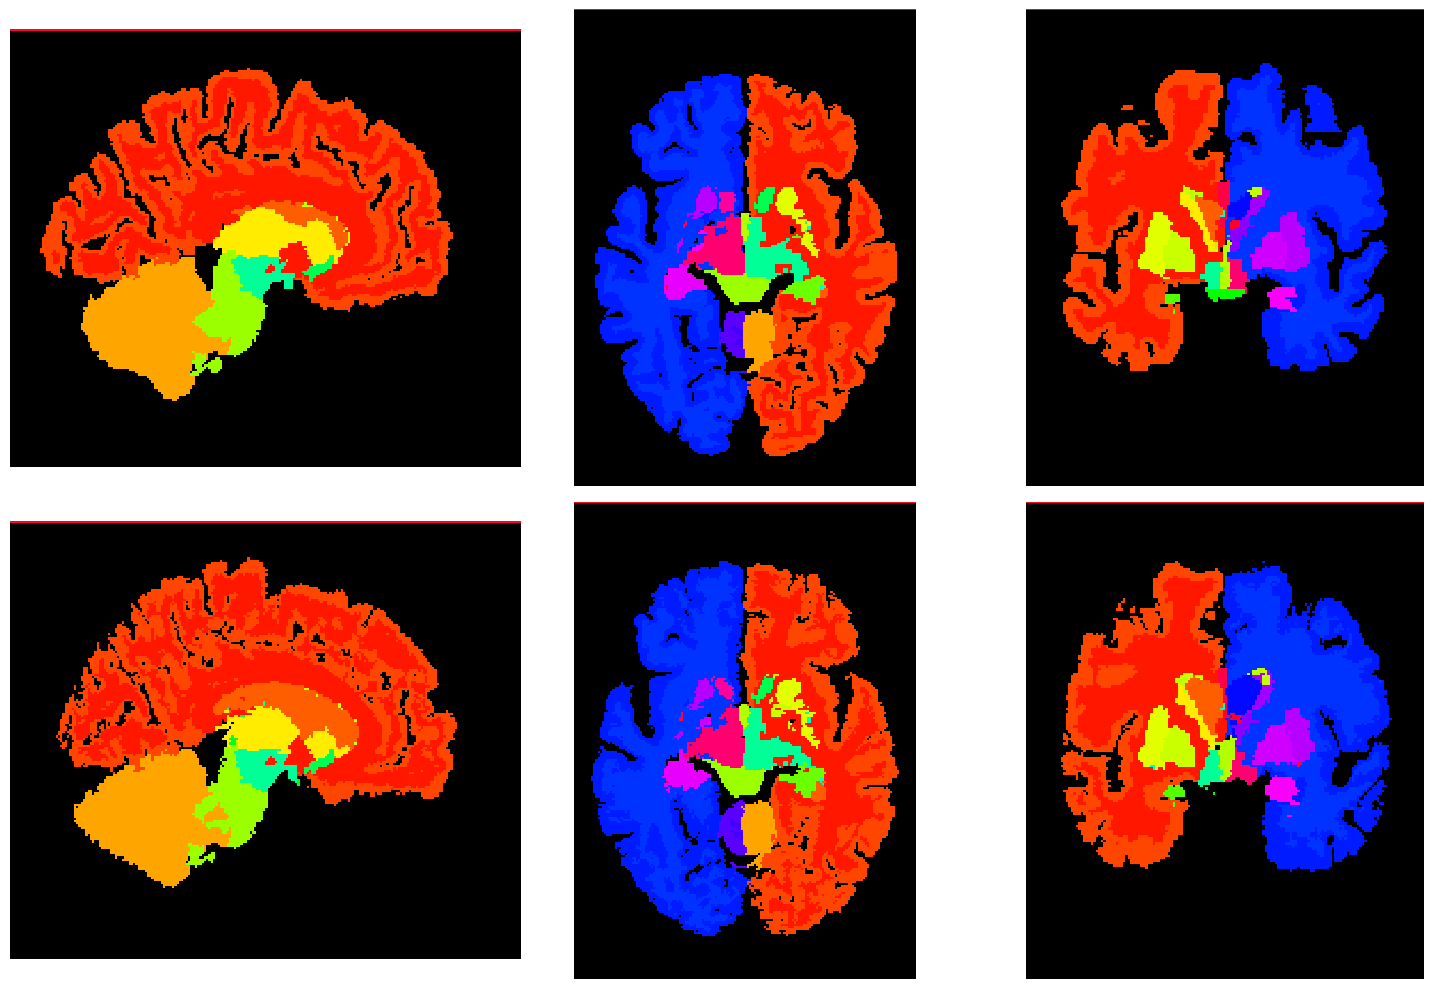

In [50]:
warp_model = vxm.networks.Transform(vol_shape, interp_method='nearest')

warped_seg = warp_model.predict([seg_volume_1[np.newaxis,...,np.newaxis], pred_warp])

from pystrum.pytools.plot import jitter
import matplotlib

[ccmap, scrambled_cmap] = jitter(255, nargout=2)
scrambled_cmap[0, :] = np.array([0, 0, 0, 1])
ccmap = matplotlib.colors.ListedColormap(scrambled_cmap)

mid_slices_fixed = [np.take(seg_volume_1, vol_shape[d]//1.8, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(warped_seg.squeeze(), vol_shape[d]//1.8, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)

slices = mid_slices_fixed + mid_slices_pred
for si, slc  in enumerate(slices):
    slices[si][0] = 255
ne.plot.slices(slices, cmaps = [ccmap], grid=[2,3]);

In [51]:
%timeit vxm_model.predict(val_input)

1/1 [==============================] - 4s 4s/step
3.69 s ± 70.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
